<a href="https://colab.research.google.com/github/ChandraMouli2214/cs666student/blob/main/CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

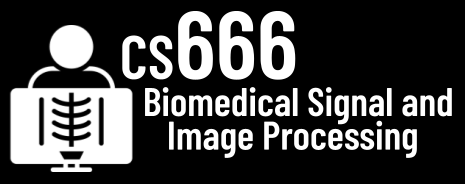
# Assignment 6

In [4]:
# NAME:Chandra Mouli Cherukuri Visweswararao

In [5]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [6]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [9]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 03:24:26--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz’

mito.npz            100%[===================>]  35.87M   224MB/s    in 0.2s    

2023-04-25 03:24:26 (224 MB/s) - ‘mito.npz’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [10]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

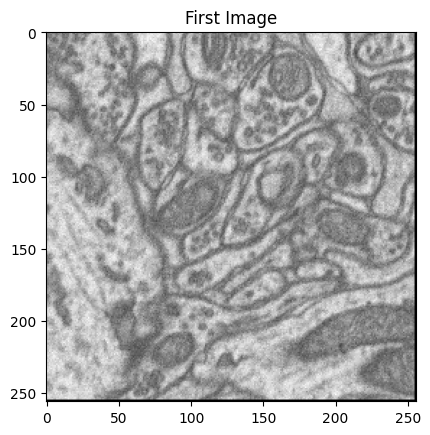

In [11]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')
plt.title("First Image")
plt.show()

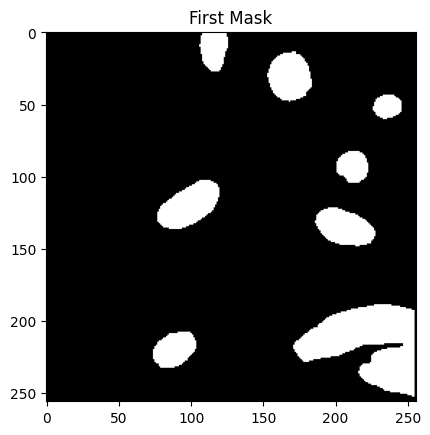

In [12]:
# TODO: Show the first mask.

plt.imshow(masks[0], cmap='gray')
plt.title("First Mask")
plt.show()

## 1. SAM in AUTO mode (15 points)

In [13]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=8a1a945a6eab15242e20dde2e1fc83a11988577d10a9be6b2f253e87914f68b0
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built metas

In [14]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [15]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [16]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


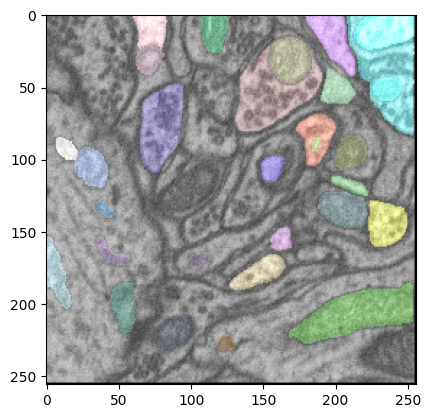

In [17]:
imshow( mh.imread('first_output.png') )

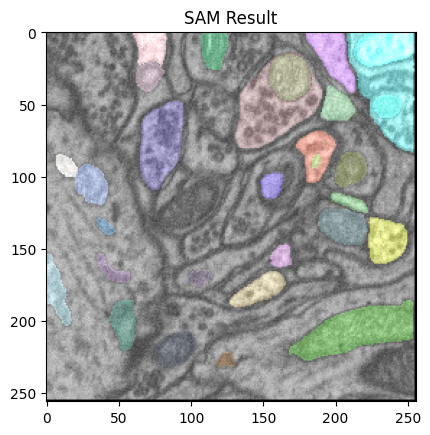

In [18]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: detected mitochondria in the output closely match the mask, then SAM works well for mitochondria detection.

# Load and display the SAM result
from PIL import Image

result_image = Image.open('first_output.png')
plt.imshow(result_image, cmap='gray')
plt.title("SAM Result")
plt.show()

Detected mitochondria in the output closely match the mask, then SAM works well for mitochondria detection.

In [19]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_l model already exists as 'vit_l.pth'. Skipping download.


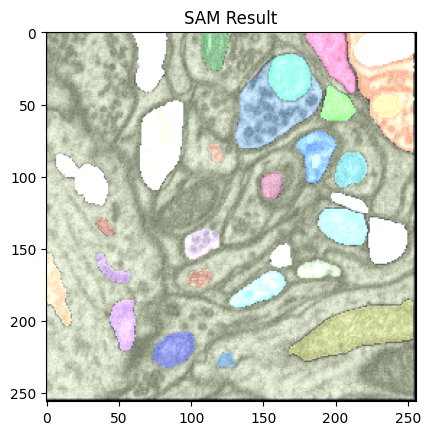

In [20]:
# TODO: YOUR CODE

uploaded_image = 'first_output.png'

# Run SAM in auto mode on the uploaded image and store the result as 'second_output.png'
results = SegAutoMaskPredictor().image_predict(
    source=uploaded_image,
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16,
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

# Display the result
result_image = Image.open('second_output.png')
plt.imshow(result_image, cmap='gray')
plt.title("SAM Result")
plt.show()


In [21]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

After, visually comparing the output with the original image, detected segments in the output closely match the desired segments in the original image. Hence, SAM works well on example image.

## 2. Train a U-Net classifier from scratch (50 points)


In [22]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


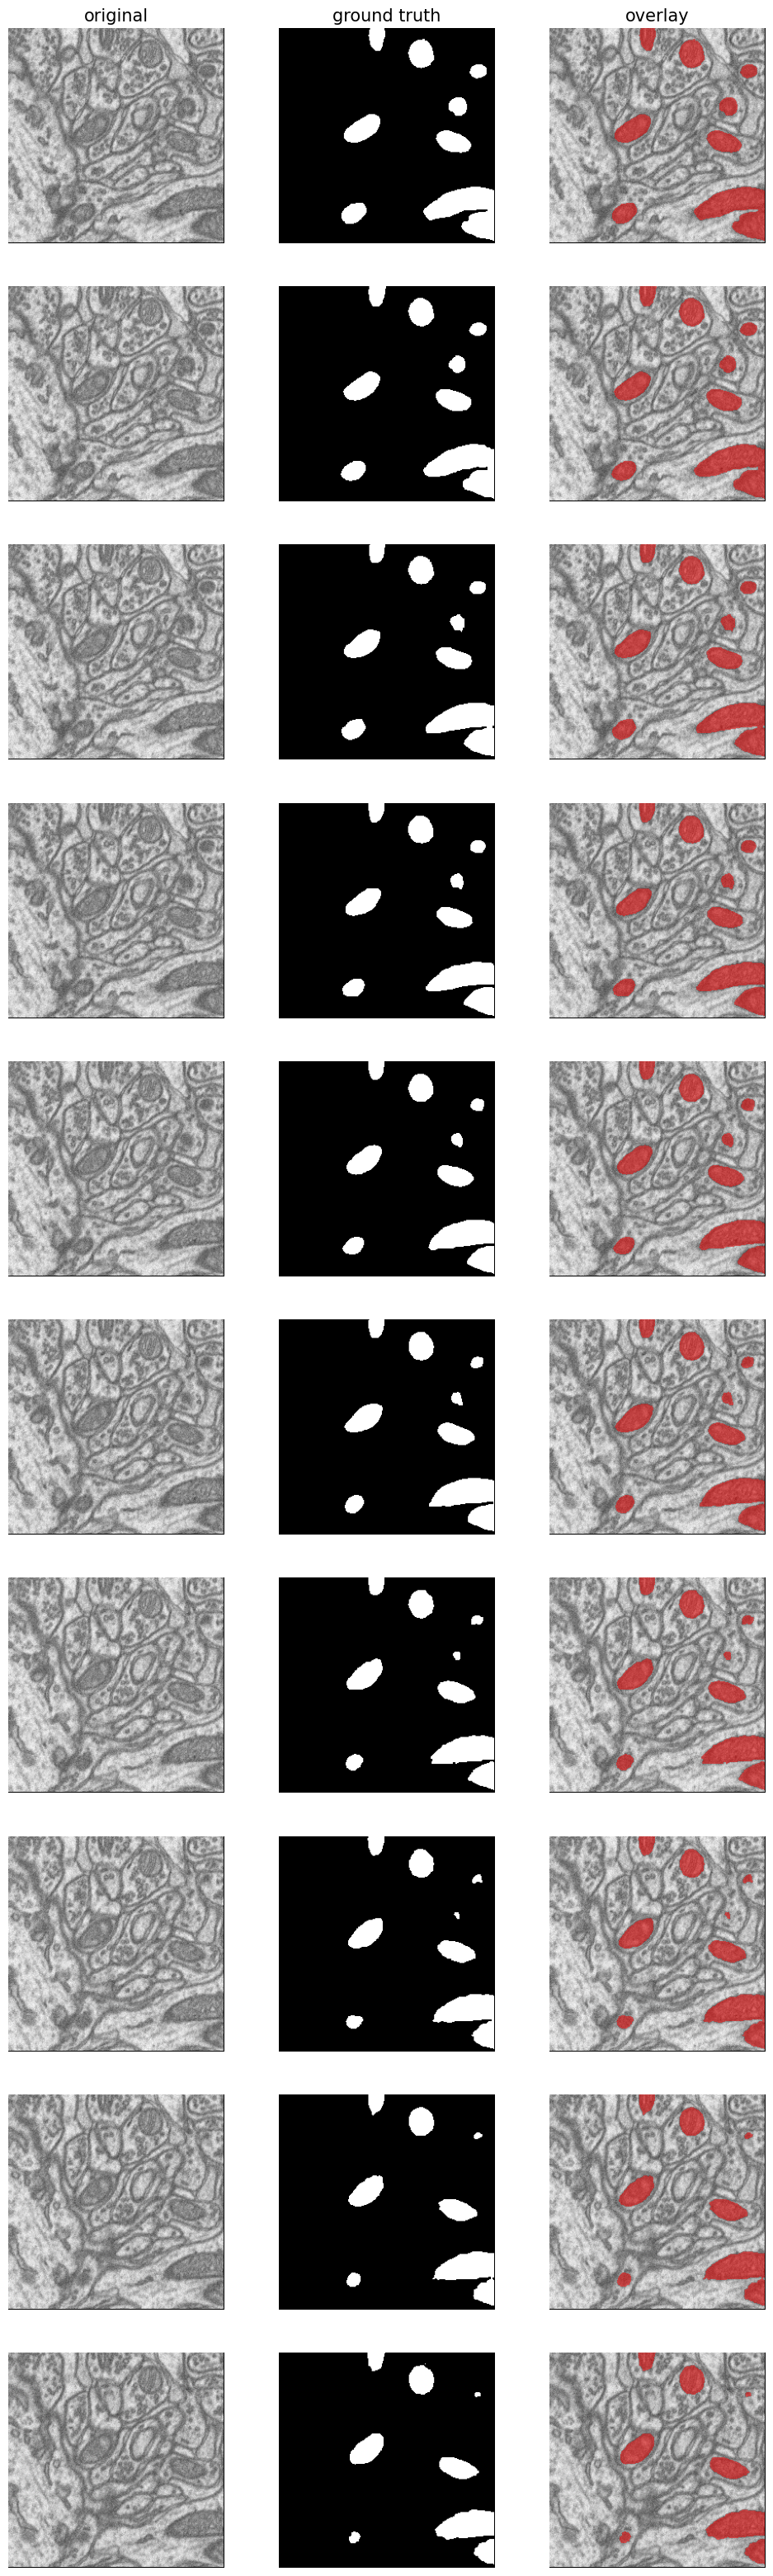

In [24]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [25]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [26]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 


# Convert to float32
images_float32 = images.astype(np.float32)

# Normalize to the range of 0 to 1
images_normalized = images_float32 / images_float32.max()

# Add the last channel using .reshape()
X = images_normalized.reshape(images_normalized.shape + (1,))

# Check the resulting shape, max value, and dtype
print(X.shape, X.max(), X.dtype)

(660, 256, 256, 1) 1.0 float32


In [27]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [28]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [29]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

# Convert to bool
masks_bool = masks.astype(np.bool)

# Add the last channel using .reshape()
y = masks_bool.reshape(masks_bool.shape + (1,))

# Check the resulting shape and dtype
print(y.shape, y.dtype)

(660, 256, 256, 1) bool


<ipython-input-29-825f8b10e1e5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks_bool = masks.astype(np.bool)


In [30]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [31]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [34]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [35]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

We call train_test_split twice to create three distinct datasets: training, validation, and testing.

In the first call to train_test_split, we split the data into two parts: training (80% of the data) and testing (20% of the data). This is done using the parameter test_size=0.2.

Then, in the second call to train_test_split, we further split the training data into two parts: training (70% of the original training data) and validation (30% of the original training data). This is done using the parameter test_size=0.3.

By doing this, we end up with three datasets:

Training data (56% of the total data): used to train the model.
Validation data (24% of the total data): used to evaluate the model during training and tune hyperparameters.
Testing data (20% of the total data): used to assess the final performance of the model after training.
This approach ensures that we have separate data for training, hyperparameter tuning, and final model evaluation, which helps prevent overfitting and provides a better estimate of the model's performance on unseen data.

In [36]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [37]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

Data augmentation is a technique used to increase the amount and diversity of the training data by applying random transformations to the original images and masks. This helps the model generalize better and prevents overfitting.

The get_augmented function takes the following arguments:

* X_train: The training images.
* y_train: The corresponding training masks.
* batch_size: The number of samples per batch during training.
* data_gen_args: A dictionary containing the parameters for data augmentation.

The data_gen_args dictionary contains the following keys and values:
* rotation_range: The range of degrees for random rotation, here set to 15 degrees.
* width_shift_range: The range for random horizontal shifts as a fraction of the total width, here set to 5%.
* height_shift_range: The range for random vertical shifts as a fraction of the total height, here set to 5%.
* shear_range: The range for random shearing transformations, here set to 50 degrees.
* zoom_range: The range for random zoom, here set to 20%.
* horizontal_flip: Whether to randomly flip images horizontally, here set to True.
* vertical_flip: Whether to randomly flip images vertically, here set to True.
* fill_mode: How to fill points outside the input boundaries, here set to 'constant' to fill with a constant value.
* train_gen is now a generator that yields augmented image and mask pairs in batches of 2 during model training. This allows the model to train on a virtually larger and more diverse dataset, which can improve its performance and generalization capabilities.

(2, 256, 256, 1) (2, 256, 256, 1)


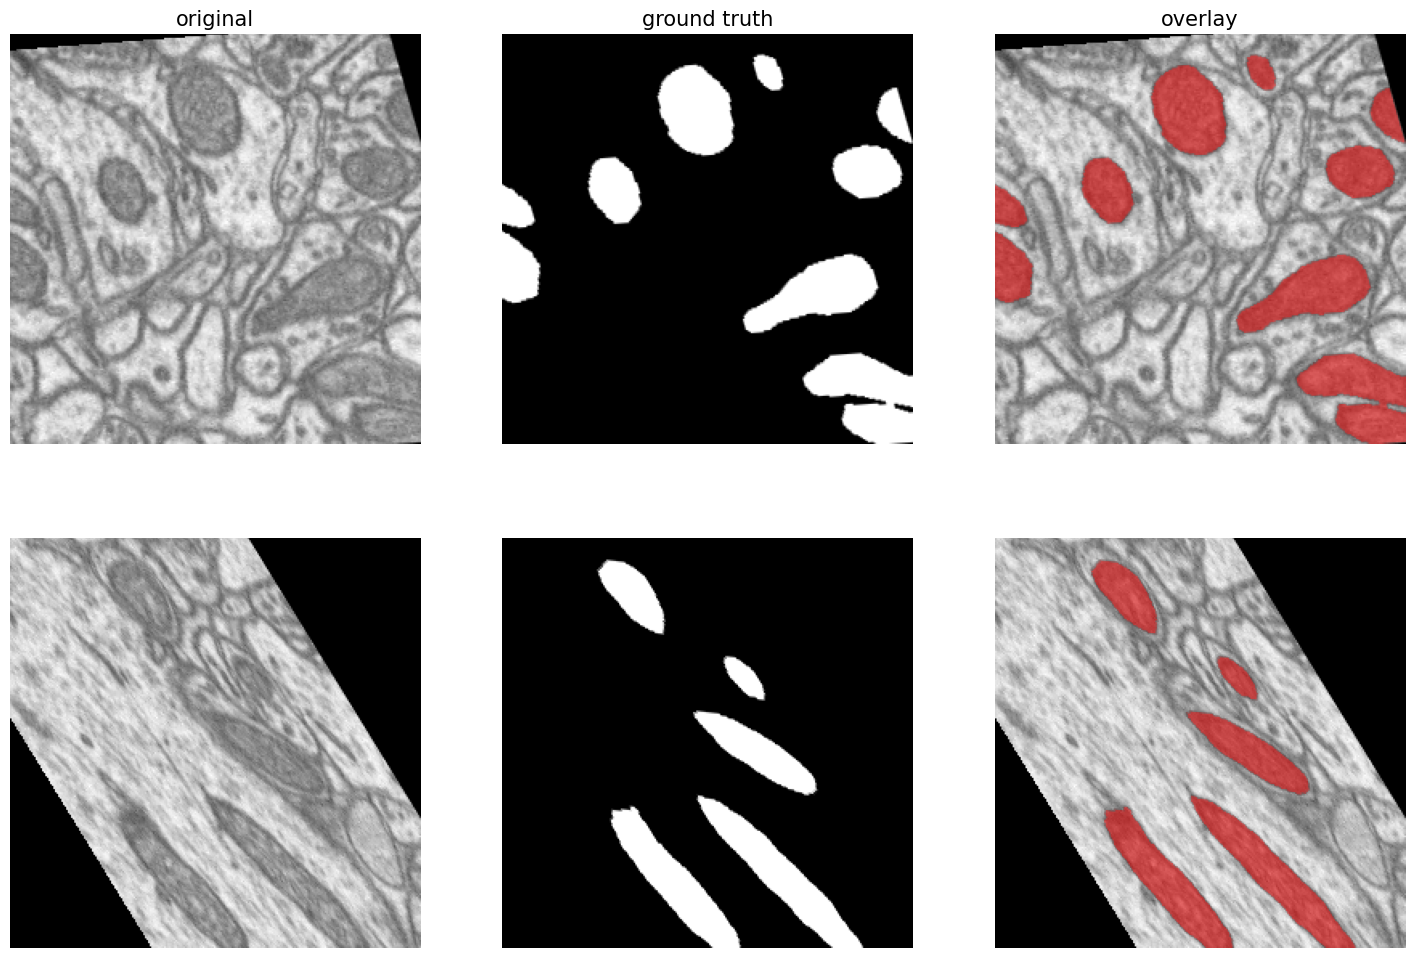

In [38]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [39]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [40]:
# TODO: How many  trainable parameters does the model use?
# TODO: Trainable params: 31,030,593

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [41]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [42]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [43]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

Intersect-over-Union (IoU) is a commonly used evaluation metric for segmentation tasks. It measures the overlap between the predicted segmentation mask and the ground truth mask, providing a quantitative estimation of the model's performance. IoU is defined as the area of intersection between the predicted and ground truth masks divided by the area of their union.

The IoU score ranges from 0 to 1. A score of 0 indicates no overlap between the predicted and ground truth masks, while a score of 1 indicates a perfect match. Higher IoU scores correspond to better segmentation performance, as they indicate greater agreement between the predicted and ground truth masks.

In [44]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(

    train_gen,
    steps_per_epoch=len(X_train),
    epochs=30,
    validation_data=(X_val, y_val),
)

Epoch 1/30
369/369 [==============================] - 105s 263ms/step - loss: 0.2217 - iou: 0.0655 - iou_thresholded: 1.9642e-04 - val_loss: 0.1892 - val_iou: 0.1353 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 56s 152ms/step - loss: 0.1709 - iou: 0.1325 - iou_thresholded: 0.0130 - val_loss: 0.1721 - val_iou: 0.1484 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
369/369 [==============================] - 56s 152ms/step - loss: 0.1386 - iou: 0.2268 - iou_thresholded: 0.1971 - val_loss: 0.1198 - val_iou: 0.2984 - val_iou_thresholded: 0.3404
Epoch 4/30
369/369 [==============================] - 56s 151ms/step - loss: 0.1183 - iou: 0.2998 - iou_thresholded: 0.3385 - val_loss: 0.1235 - val_iou: 0.2713 - val_iou_thresholded: 0.0240
Epoch 5/30
369/369 [==============================] - 57s 155ms/step - loss: 0.1006 - iou: 0.3879 - iou_thresholded: 0.4759 - val_loss: 0.0622 - val_iou: 0.6081 - val_iou_thresholded: 0.7347
Epoch 6/30
369/369 [============

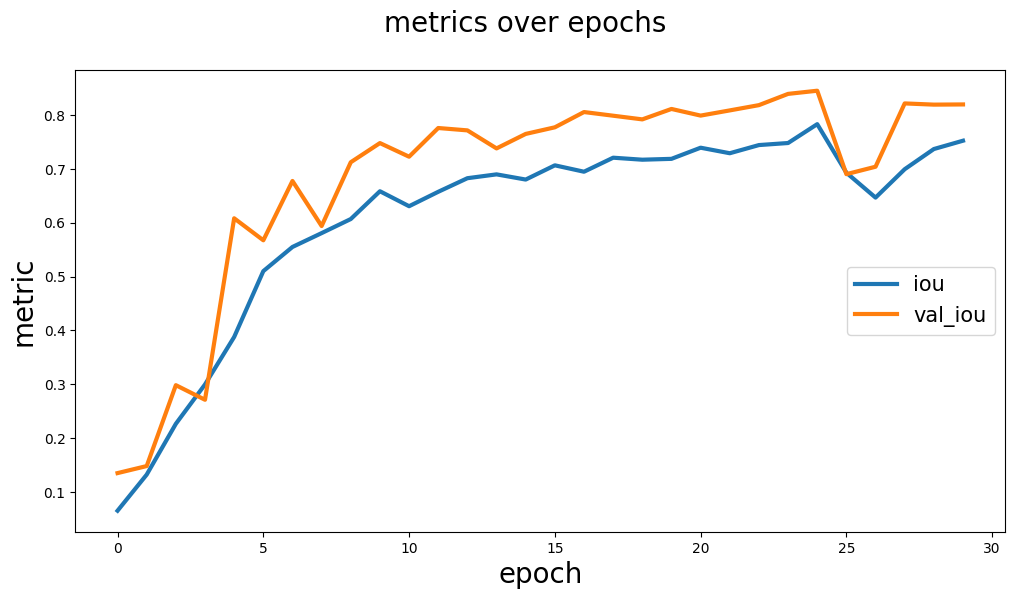

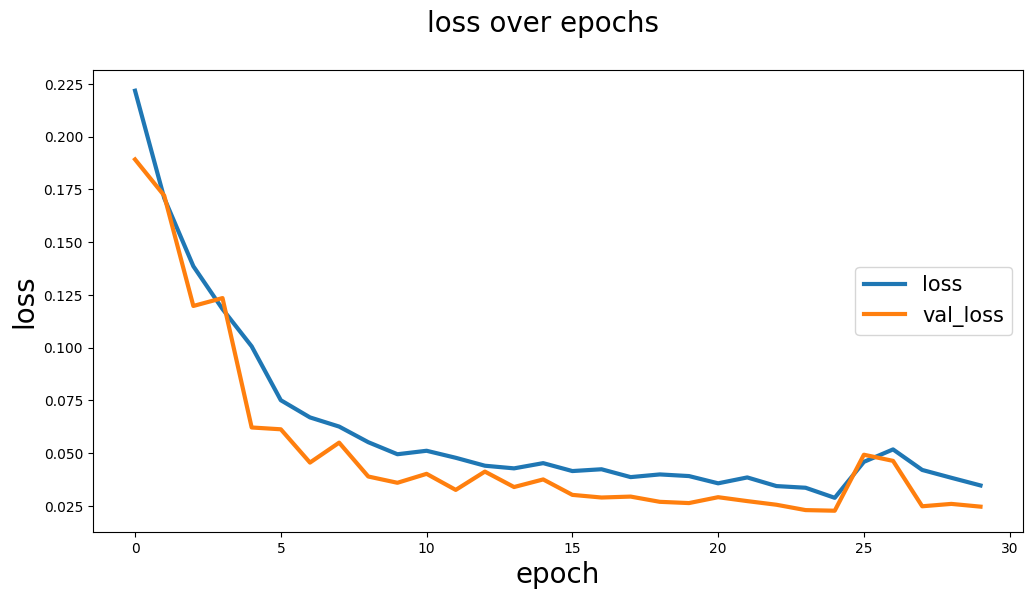

In [45]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [46]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

Training Loss and Validation Loss: Ideally, both the training and validation loss should decrease over time and converge to a low value, which is a good sign.

IoU and Thresholded IoU: The Intersection-over-Union (IoU) and thresholded IoU metrics should ideally increase over time, approaching a high value close to 1. A higher IoU indicates better performance of the model in terms of mask prediction.

## 3. Evaluate U-Net (10 points)

In [47]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 4s 1s/step


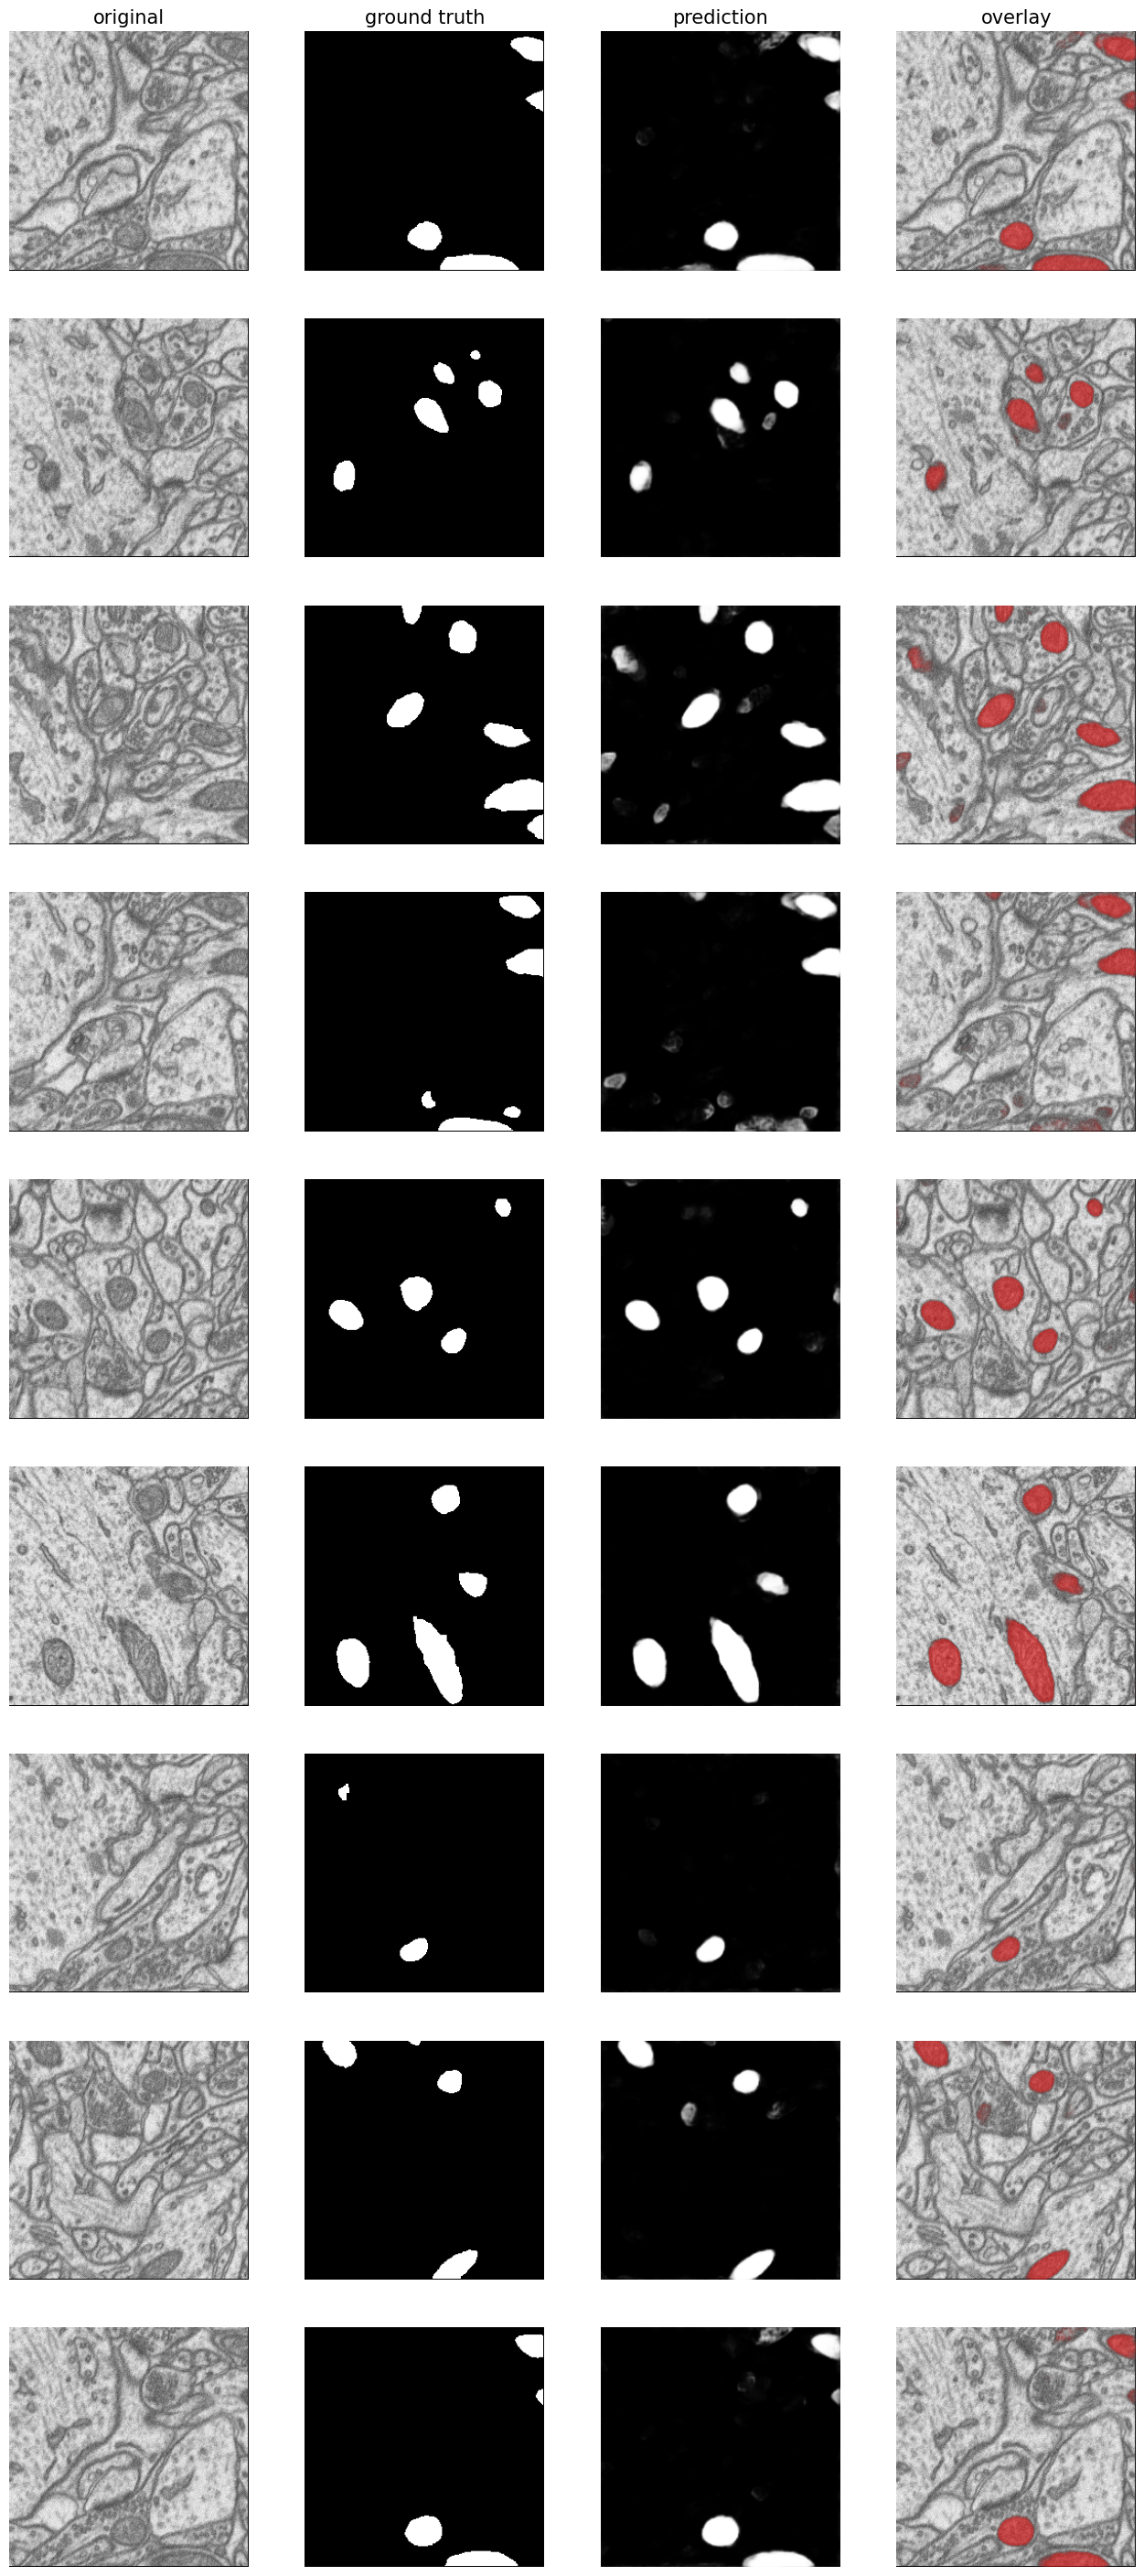

In [48]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [49]:
import sklearn.metrics

In [50]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.884017816224506

In [51]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

The Jaccard Score and Intersect-over-Union (IoU) are essentially the same metric. Both measure the overlap between two sets, in this case, the predicted segmentation mask and the ground truth mask. The metric is calculated as the area of intersection divided by the area of the union.

In [52]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

The given Jaccard Score (IoU) for the U-Net on X_test is 0.8868, which is close to 1. This indicates a high degree of overlap between the predicted segmentation masks and the ground truth masks. Based on this metric, it can be concluded that the U-Net performed well on the X_test dataset.

## 4. Combine U-Net with SAM (10 points)

In [53]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [54]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [55]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [56]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [57]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [58]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

I'll explain the code block by block:

#### Save the test image to disk:

`mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))`

This line of code saves the current test image img from X_test to a file named 'test.png' with the same pixel values (multiplied by 255 to convert the normalized values back to the 0-255 range) and data type (np.uint8).


#### Threshold the U-Net prediction:

`pred = (y_pred[z] > 0.5)`

This line creates a binary mask pred by thresholding the predicted mask at a value of 0.5.


#### Label connected components in the thresholded prediction:

`pred, _ = mh.labeled.label(pred)`

This line labels the connected components in the thresholded prediction pred and assigns the result back to pred. The second output, which is the number of connected components, is not used and is therefore assigned to a dummy variable _.

#### Compute bounding boxes for connected components:

`bbs = mh.labeled.bbox(pred)``

This line calculates the bounding boxes for the connected components in the labeled pred image and stores them in the bbs variable.


#### Convert mahotas bounding boxes to SAM format:

`bbs_converted = mahotas_bbox_to_sam(bbs)`

This line converts the bounding boxes from the mahotas format to the SAM format using the mahotas_bbox_to_sam function.


#### Run SAM model with the converted bounding boxes:

```
results = SegManualMaskPredictor().image_predict(
    source="test.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    input_box=bbs_converted, 
    multimask_output=False,
    random_color=False,
    show=False,
    save=False,
)
```
This line runs the SAM model using the SegManualMaskPredictor with the U-Net seeded bounding boxes (bbs_converted). The SAM model takes the saved test image "test.png" as input and predicts the segmentation mask.


#### Combine SAM output tensors to a mask:

`sam_and_unet_pred = sam_to_mask(results)`

This line combines the SAM output tensors into a single binary mask using the sam_to_mask function.


#### Store the combined SAM and U-Net prediction in y_pred_sam:

`y_pred_sam[z,:,:,0] = sam_and_unet_pred`

This line stores the combined SAM and U-Net prediction (sam_and_unet_pred) in the y_pred_sam array for the current test image z.

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [59]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.884017816224506

In [60]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8506288233111966

In [61]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

The results show that the performance of U-Net alone on X_test is better (Jaccard Score of 0.88) than the combination of U-Net and SAM (Jaccard Score of 0.81). In this case, it seems that U-Net+SAM is not a good addition, as the performance has slightly decreased when using the combined approach. This might be due to various factors such as suboptimal seeding or possible issues with the SAM model configuration.

One potential reason for the lower performance of the combined approach could be that the SAM model might not be well-suited for the specific task of mitochondria detection or might require fine-tuning for this particular application. It is also possible that the SAM model is not effectively leveraging the seed information provided by the U-Net predictions, which could be further investigated and improved.

In conclusion, based on the results, U-Net+SAM is not a good addition for this specific task, and using U-Net alone yields better performance. Further investigation and optimization might be needed to improve the combined approach.

## Bonus: Improve the results. (33 points)

In [62]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [63]:
# TODO: YOUR_CODE

In [64]:
from skimage.morphology import binary_closing
import warnings
warnings.filterwarnings('ignore')

points_per_side = 32
points_per_batch = 128
model_type = "vit_l"

def sam_to_mask(results):
    results = results.cpu()
    mask = np.array(results[0,0])
    for s in results:
        mask[s[0] == 1] = 1
    mask = binary_closing(mask, selem=np.ones((5,5)))
    
    return mask

y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  pred = (y_pred[z] > 0.5)
  pred, _ = mh.labeled.label(pred)
  bbs = mh.labeled.bbox(pred)
  bbs_converted = mahotas_bbox_to_sam(bbs)
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type=model_type,
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  sam_and_unet_pred = sam_to_mask(results)
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

  # Calculate the Jaccard score for the improved U-Net+SAM
  jaccard_score_improved = sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())
  print("Improved Jaccard score for U-Net+SAM: ", jaccard_score_improved)

vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.004483017182240232
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.008096429818978759
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.015449702088090211
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.01897000878962284
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.022995118106232042
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.031089276240759623
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.0319495313031076
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.035355579790552476
vit_l model already exists 

Improved Jaccard score for U-Net+SAM:  0.83799583950758

In [65]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#Collab With Rithvik Reddy Paluchani